## Data Mining, Text Mining and Big Data Analytics
### BDA Project + mini project with extra 3 CFUs
### Wenxi Huo_1035935
### wenxi.huo@studio.unibo.it

The dataset named Black Friday Sales contains customer demographics (age, gender, marital status, city type, stay_in_current_city), product details (product_id and product category), and Total purchase amount. In the project, the specific content is as follow:

1. Read and clean the data
2. Exploratory Data Analysis
* 2.1 What are the top products?
* 2.2 How does age also affect the purchases?
* 2.3 How does gender affect the purchases?
* 2.4 What is the relationship between the occupation and the purchases?
3. Based on all the data, train the classifier model with the occupation as the label: 
* a.StringIndexer  
* b.VectorAssembler
* c.KMeans
* d.DecisionTreeClassifier  
* e.RandomForestClassifier
* f.MulticlassClassificationEvaluator

#### For the mini project(3cfu):
1. Compare the relationship between different categorial variables with product_category purchased.
2. Calculate the similarity between different product_category by: 
3. Regression algorithm prediction of purchases:
* a. LinearRegressor 
* b.DecisionTreeRegressor 
* c.RandomForestRegressor 
* d.Regression Evaluator

### Import necessary libraries

In [118]:
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
from pyspark.ml import Pipeline 
from pyspark.ml.clustering import KMeans   
from pyspark.ml.feature import StringIndexer, StandardScaler, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator,ClusteringEvaluator
from pyspark.sql.functions import col, when
import matplotlib.pyplot as plt  
import numpy as np  
import seaborn as sns 

In [2]:
# Initialize a SparkSession.
spark = SparkSession.builder.appName("BlackFridaySalesAnalysis").config("spark.sql.legacy.timeParserPolicy", "LEGACY").getOrCreate()

### Data Preparation and Pre-processing

In [174]:
#Read csv data files 
data = spark.read.csv("train.csv", header=True, inferSchema=True)
data.printSchema()

root
 |-- User_ID: integer (nullable = true)
 |-- Product_ID: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Occupation: integer (nullable = true)
 |-- City_Category: string (nullable = true)
 |-- Stay_In_Current_City_Years: string (nullable = true)
 |-- Marital_Status: integer (nullable = true)
 |-- Product_Category_1: integer (nullable = true)
 |-- Product_Category_2: integer (nullable = true)
 |-- Product_Category_3: integer (nullable = true)
 |-- Purchase: integer (nullable = true)



In [173]:
data.show(5)

+-------+----------+------+----+----------+-------------+--------------------------+--------------+------------------+------------------+------------------+--------+
|User_ID|Product_ID|Gender| Age|Occupation|City_Category|Stay_In_Current_City_Years|Marital_Status|Product_Category_1|Product_Category_2|Product_Category_3|Purchase|
+-------+----------+------+----+----------+-------------+--------------------------+--------------+------------------+------------------+------------------+--------+
|1000001| P00069042|     F|0-17|        10|            A|                         2|             0|                 3|              NULL|              NULL|    8370|
|1000001| P00248942|     F|0-17|        10|            A|                         2|             0|                 1|                 6|                14|   15200|
|1000001| P00087842|     F|0-17|        10|            A|                         2|             0|                12|              NULL|              NULL|    1422|
|100

In [5]:
# Check rows which has null values
null_counts = data.select([col(column).alias(column + "_null_count") for column in data.columns])
null_counts.show(5)

+------------------+---------------------+-----------------+--------------+---------------------+------------------------+-------------------------------------+-------------------------+-----------------------------+-----------------------------+-----------------------------+-------------------+
|User_ID_null_count|Product_ID_null_count|Gender_null_count|Age_null_count|Occupation_null_count|City_Category_null_count|Stay_In_Current_City_Years_null_count|Marital_Status_null_count|Product_Category_1_null_count|Product_Category_2_null_count|Product_Category_3_null_count|Purchase_null_count|
+------------------+---------------------+-----------------+--------------+---------------------+------------------------+-------------------------------------+-------------------------+-----------------------------+-----------------------------+-----------------------------+-------------------+
|           1000001|            P00069042|                F|          0-17|                   10|            

By reviewing our data, we found that those missing values are cells that were left empty on purpose, 
because they represent cases in which the product didn't belong to either both or one of the 
other product categories (Product_Category_2 or Product_Category_3) which is the majority cases.
So, we're going to fill them with the value of zero (0).

In [6]:
# Fill the missing values with zero
df_filled = data.na.fill(0)
df_filled.show(5)

+-------+----------+------+----+----------+-------------+--------------------------+--------------+------------------+------------------+------------------+--------+
|User_ID|Product_ID|Gender| Age|Occupation|City_Category|Stay_In_Current_City_Years|Marital_Status|Product_Category_1|Product_Category_2|Product_Category_3|Purchase|
+-------+----------+------+----+----------+-------------+--------------------------+--------------+------------------+------------------+------------------+--------+
|1000001| P00069042|     F|0-17|        10|            A|                         2|             0|                 3|                 0|                 0|    8370|
|1000001| P00248942|     F|0-17|        10|            A|                         2|             0|                 1|                 6|                14|   15200|
|1000001| P00087842|     F|0-17|        10|            A|                         2|             0|                12|                 0|                 0|    1422|
|100

### Exploratory Data Analysis

In [7]:
 # 1.What are the top10 products?
top_products = data.groupBy("Product_ID").agg({"Purchase": "sum"}).orderBy(col("sum(Purchase)").desc())  
top_products.show(10)  

+----------+-------------+
|Product_ID|sum(Purchase)|
+----------+-------------+
| P00025442|     27995166|
| P00110742|     26722309|
| P00255842|     25168963|
| P00059442|     24338343|
| P00184942|     24334887|
| P00112142|     24216006|
| P00110942|     23639564|
| P00237542|     23425576|
| P00057642|     23102780|
| P00010742|     22164153|
+----------+-------------+
only showing top 10 rows



We can see the top 10 products above.

In [8]:
# 2. How does age affect the purchases? 
age_purchase = data.groupBy("Age").agg({"Purchase": "sum"}).orderBy("Age")  
age_purchase.show() 

+-----+-------------+
|  Age|sum(Purchase)|
+-----+-------------+
| 0-17|    134913183|
|18-25|    913848675|
|26-35|   2031770578|
|36-45|   1026569884|
|46-50|    420843403|
|51-55|    367099644|
|  55+|    200767375|
+-----+-------------+



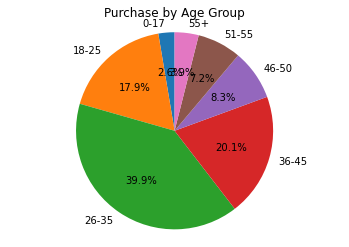

In [175]:
age_purchase_collected = age_purchase.collect()   
ages = [row[0] for row in age_purchase_collected]  
purchase_sum = [row[1] for row in age_purchase_collected]  
   
ages_str = [str(age) for age in ages]  
   
fig, ax = plt.subplots()  
ax.pie(purchase_sum, labels=ages_str, autopct='%1.1f%%', startangle=90)  
ax.axis('equal')   
plt.title("Purchase by Age Group")   
plt.show()

We can see that the majority are for people aging between 26-35 being the most buyers with about 40% of total purchases.

In [10]:
#3.  How does gender affect the purchases? 
gender_purchase = data.groupBy("gender").agg({"Purchase": "sum"})  
gender_purchase.show() 

+------+-------------+
|gender|sum(Purchase)|
+------+-------------+
|     F|   1186232642|
|     M|   3909580100|
+------+-------------+



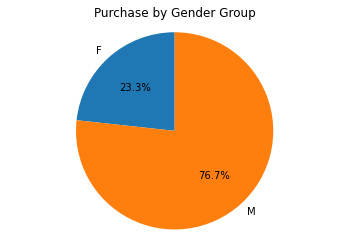

In [11]:
gender_purchase_collected = gender_purchase.collect()  
gen = [row[0] for row in gender_purchase_collected]  
gender_sum = [row[1] for row in gender_purchase_collected]  
    
gender_str = [str(gender) for gender in gen]    
fig, ax = plt.subplots()  
ax.pie(gender_sum, labels=gender_str, autopct='%1.1f%%', startangle=90)  
ax.axis('equal')  
plt.title("Purchase by Gender Group")   
plt.show()

We can see that the majority of the purchases that have been done is by the males.

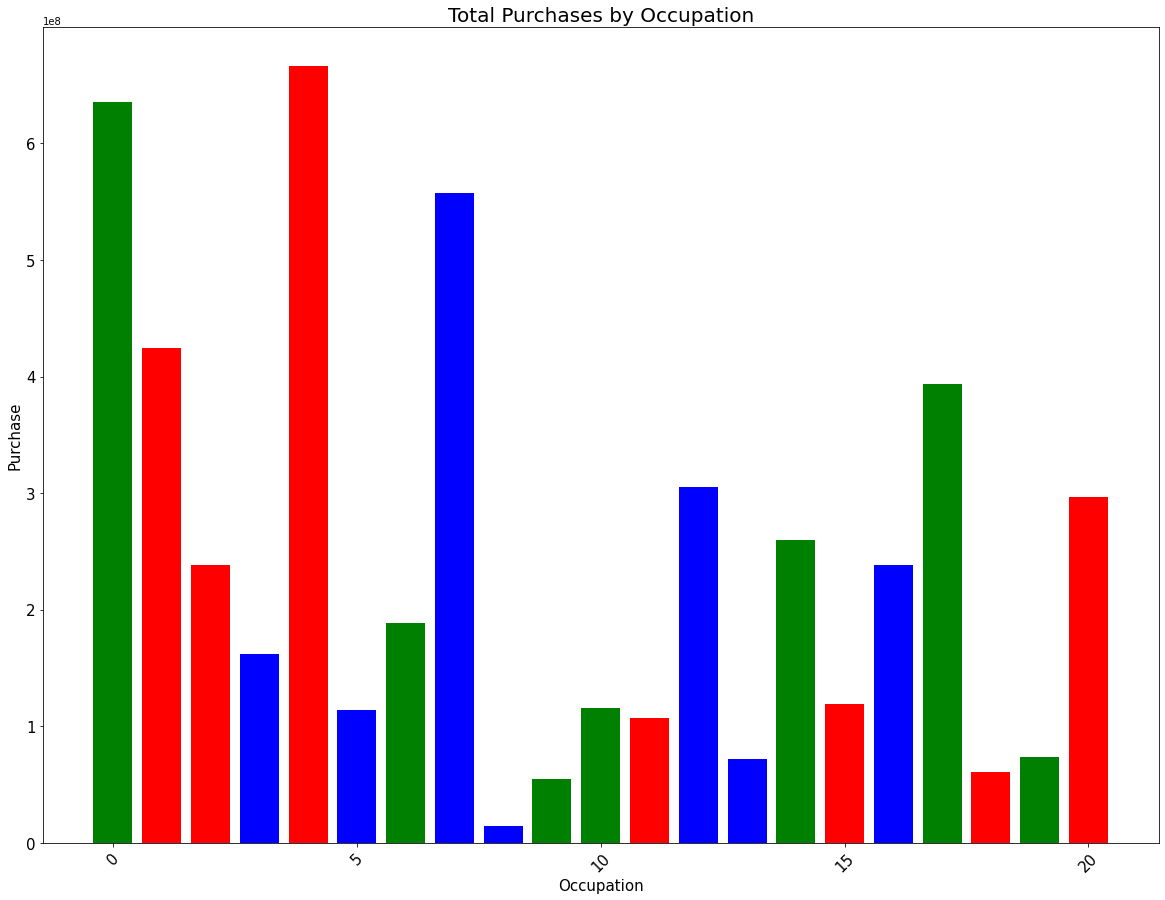

In [179]:
# 4. the relationship between the occupation and the purchases  
occ_purchases = (data  
                 .groupBy("Occupation")  
                 .agg({"Purchase": "sum"})  
                 .withColumnRenamed("sum(Purchase)", "TotalPurchase")  
                 .orderBy("TotalPurchase", ascending=False)   
                )  

local_data = occ_purchases.toPandas() 
local_data_sorted = local_data.sort_values(by="TotalPurchase", ascending=False) 
  
plt.figure(figsize=(20, 15))  
plt.bar(local_data_sorted["Occupation"], local_data_sorted["TotalPurchase"], color=('red', 'green', 'blue'))  
plt.xticks(rotation=45, fontsize=15)  
plt.yticks(fontsize=15)  
plt.xlabel("Occupation", fontsize=15)  
plt.ylabel("Purchase", fontsize=15)  
plt.title('Total Purchases by Occupation', color='black', fontsize=20) 
  
#for i, row in local_data_sorted.iterrows():  
 #   plt.text(i, row["TotalPurchase"], '$' + str(row["TotalPurchase"]), fontsize=15, rotation=45, color='k', ha='center', va='bottom')  
plt.show()  

We noticed that the top 3 occupations with the most purchases are descendingly: 4, 0, then 7.

In [181]:
#Feature Engineering to convert Purchase into Category 
#Sort according to the value of 'Purchase' 
df = df_filled.withColumn(  
    "Purchase_Category",  
    when(col("Purchase") <= 1000, 'Less Than 1000')  
    .when((col("Purchase") > 1000) & (col("Purchase") <= 5000), 'Less Than 5000')  
    .when((col("Purchase") > 5000) & (col("Purchase") <= 10000), 'Less Than 10000')  
    .when((col("Purchase") > 10000) & (col("Purchase") <= 15000), 'Less Than 15000')  
    .otherwise('Greater Than 15000')  
)   
df.select(['Purchase_Category']).show(10)

+------------------+
| Purchase_Category|
+------------------+
|   Less Than 10000|
|Greater Than 15000|
|    Less Than 5000|
|    Less Than 5000|
|   Less Than 10000|
|Greater Than 15000|
|Greater Than 15000|
|Greater Than 15000|
|Greater Than 15000|
|   Less Than 10000|
+------------------+
only showing top 10 rows



In [14]:
# Select the specific columns and create a new DataFrame  
selected_df = df.select(  
    'Gender', 'Occupation', 'City_Category',  
    'Stay_In_Current_City_Years', 'Marital_Status', 'Age', 'Purchase_Category'  
)   
selected_df.show(5)  

+------+----------+-------------+--------------------------+--------------+----+------------------+
|Gender|Occupation|City_Category|Stay_In_Current_City_Years|Marital_Status| Age| Purchase_Category|
+------+----------+-------------+--------------------------+--------------+----+------------------+
|     F|        10|            A|                         2|             0|0-17|   Less Than 10000|
|     F|        10|            A|                         2|             0|0-17|Greater Than 15000|
|     F|        10|            A|                         2|             0|0-17|    Less Than 5000|
|     F|        10|            A|                         2|             0|0-17|    Less Than 5000|
|     M|        16|            C|                        4+|             0| 55+|   Less Than 10000|
+------+----------+-------------+--------------------------+--------------+----+------------------+
only showing top 5 rows



In [22]:
# splitting data into x and y
#x= df[[ 'Gender', 'Occupation', 'City_Category',
 #      'Stay_In_Current_City_Years', 'Marital_Status', 'Age']]
#y= df[['Purchase_Category']]
#y.show()

#### Train the classifier model with the occupation as the label

In [100]:
#Classifier 

occu_indexer = StringIndexer(inputCol="Occupation", outputCol="Occ")
gender_indexer = StringIndexer(inputCol="Gender", outputCol="Gender_n")  
city_category_indexer = StringIndexer(inputCol="City_Category", outputCol="City_Category_n")  
stay_years_indexer = StringIndexer(inputCol="Stay_In_Current_City_Years", outputCol="Stay_In_Current_City_Years_n")  
purchase_category_indexer = StringIndexer(inputCol="Purchase_Category", outputCol="Cat")
  
pipeline = Pipeline(stages=[occu_indexer,gender_indexer, city_category_indexer, stay_years_indexer,purchase_category_indexer])    
df_c = pipeline.fit(selected_df).transform(selected_df)  
  
#df_c.show(10)
df_c.select(['Occ']).show(5)

+----+
| Occ|
+----+
|12.0|
|12.0|
|12.0|
|12.0|
| 9.0|
+----+
only showing top 5 rows



The Pipeline allows us to combine multiple data processing steps into a single stage. That means we can complete multiple preprocessing tasks in one step without having to execute each step separately. Not only simplifies the code but also improves execution efficiency.

In [111]:
assembler = VectorAssembler(inputCols=['Cat','Marital_Status','Gender_n','City_Category_n','Stay_In_Current_City_Years_n'], outputCol="features")  
output_c = assembler.transform(df_c).select(['features','Occ']) 
output_c.show(3)

+--------------------+----+
|            features| Occ|
+--------------------+----+
|[0.0,0.0,1.0,2.0,...|12.0|
|[1.0,0.0,1.0,2.0,...|12.0|
|[2.0,0.0,1.0,2.0,...|12.0|
+--------------------+----+
only showing top 3 rows



In [110]:
#Normalize
normaliser = StandardScaler(inputCol="features", outputCol="normFeatures_c")
normModel_c = normaliser.fit(output_c)
norm_c = normModel.transform(output_c)
features_norm_c = norm_c.select(["normFeatures_c", "Occ"])
features_norm_c.show(3)

+--------------------+----+
|      normFeatures_c| Occ|
+--------------------+----+
|[0.0,0.0,2.319080...|12.0|
|[0.84697110522504...|12.0|
|[1.69394221045009...|12.0|
+--------------------+----+
only showing top 3 rows



In [112]:
# Separate the dataset into training set and testset
training_data_c, test_data_c = features_norm_c.randomSplit([0.7, 0.3],seed=15) 

In [126]:
#Build KMeans model
#a. Kmeans  
k = 3  
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")  
model = kmeans.fit(output_c)  
  
# Gets the cluster center point  
centers = model.clusterCenters()
print("The 3 characteristic values of features are:",centers)

evaluator = ClusteringEvaluator()
silhouette_scorekm = evaluator.evaluate(model.transform(output_c))
print(f"Silhouette Score of KMeans: {silhouette_scorekm}")

The 3 characteristic values of features are: [array([0.24081619, 0.41652057, 0.26477973, 0.82855554, 0.65140432]), array([0.98479808, 0.39673784, 0.22105865, 0.88345384, 3.31150073]), array([2.60402438, 0.41427624, 0.2479251 , 0.83773874, 0.77664614])]
Silhouette Score of KMeans: 0.48954608107693387


The Silhouette Score is a metric measures how closely each sample is related to its own cluster and how well-separated it is from other clusters. 

As shown above, the Silhouette Score of 0.48954608107693387 for KMeans clustering indicates a moderately good but not exceptional clustering performance. This value suggests that most samples are relatively similar to other samples within their own clusters but still have some similarity to neighboring clusters, indicating possible overlap or misclassification.

In [130]:
# Build DecisionTreeClassifier model and RandomForestClassifier model  
# b. Decision Tree Classifier 
dt_c = DecisionTreeClassifier(featuresCol="normFeatures_c", labelCol="Occ")  
dt_model_c = dt_c.fit(training_data_c)  
  
# c. Random Forest Classifier 
rf_c = RandomForestClassifier(featuresCol="normFeatures_c", labelCol="Occ")  
rf_model_c = rf_c.fit(training_data_c)  

In [134]:
# prediction 
dt_pred_c = dt_model_c.transform(test_data_c)  
rf_pred_c = rf_model_c.transform(test_data_c)

In [137]:
# Evaluate for DecisionTreeClassifier 
dt_evaluator = MulticlassClassificationEvaluator(  
    labelCol="Occ", predictionCol="prediction", metricName="accuracy")  
dt_accuracy = dt_evaluator.evaluate(dt_pred_c)  
  
#Evaluate for RandomTreeClassifier 
rf_evaluator = MulticlassClassificationEvaluator(  
    labelCol="Occ", predictionCol="prediction", metricName="accuracy")  
rf_accuracy = rf_evaluator.evaluate(rf_pred_c)  
  
print(f"Decision Tree Accuracy: {dt_accuracy}")  
print(f"Random Forest Accuracy: {rf_accuracy}")

Decision Tree Accuracy: 0.16960594452505115
Random Forest Accuracy: 0.16960594452505115


In [157]:
#Compare the relationship between different categorial variables with product_category purchased.
p_purchase_1 = df_filled.groupBy("Product_Category_1").agg({"Purchase": "sum"}).orderBy("Product_Category_1")  
p_purchase_2 = df_filled.groupBy("Product_Category_2").agg({"Purchase": "sum"}).orderBy("Product_Category_2")
p_purchase_3 = df_filled.groupBy("Product_Category_3").agg({"Purchase": "sum"}).orderBy("Product_Category_3")
p_purchase_1.show(3)
p_purchase_2.show(3)
p_purchase_3.show(3)

+------------------+-------------+
|Product_Category_1|sum(Purchase)|
+------------------+-------------+
|                 1|   1910013754|
|                 2|    268516186|
|                 3|    204084713|
+------------------+-------------+
only showing top 3 rows

+------------------+-------------+
|Product_Category_2|sum(Purchase)|
+------------------+-------------+
|                 0|   1305531230|
|                 2|    670303864|
|                 3|     32402777|
+------------------+-------------+
only showing top 3 rows

+------------------+-------------+
|Product_Category_3|sum(Purchase)|
+------------------+-------------+
|                 0|   3150994343|
|                 3|      8545034|
|                 4|     18364475|
+------------------+-------------+
only showing top 3 rows



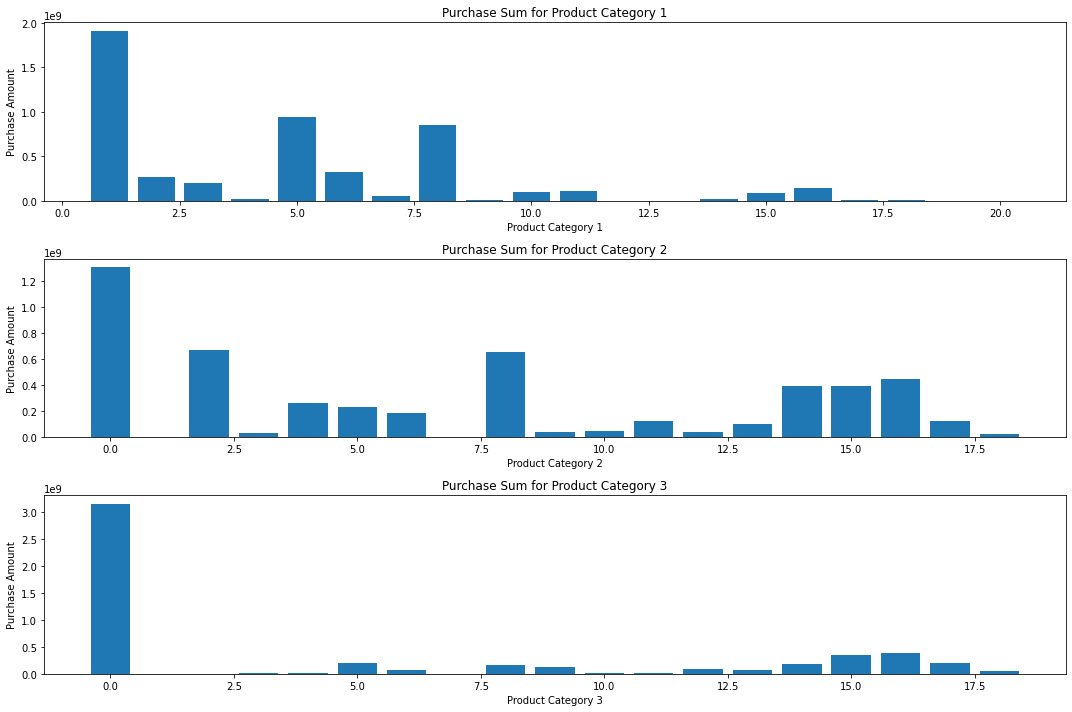

In [155]:
p_purchase_1_pd = p_purchase_1.toPandas()  
p_purchase_2_pd = p_purchase_2.toPandas()  
p_purchase_3_pd = p_purchase_3.toPandas()  
  
plt.figure(figsize=(15, 10))  
  
plt.subplot(3, 1, 1)   
plt.bar(p_purchase_1_pd["Product_Category_1"], p_purchase_1_pd["sum(Purchase)"])  
plt.title("Purchase Sum for Product Category 1")  
plt.xlabel("Product Category 1")  
plt.ylabel("Purchase Amount")  
  
plt.subplot(3, 1, 2)  
plt.bar(p_purchase_2_pd["Product_Category_2"], p_purchase_2_pd["sum(Purchase)"])  
plt.title("Purchase Sum for Product Category 2")  
plt.xlabel("Product Category 2")  
plt.ylabel("Purchase Amount")  
  
plt.subplot(3, 1, 3)   
plt.bar(p_purchase_3_pd["Product_Category_3"], p_purchase_3_pd["sum(Purchase)"])  
plt.title("Purchase Sum for Product Category 3")  
plt.xlabel("Product Category 3")  
plt.ylabel("Purchase Amount")  
    
plt.tight_layout()   
plt.show()

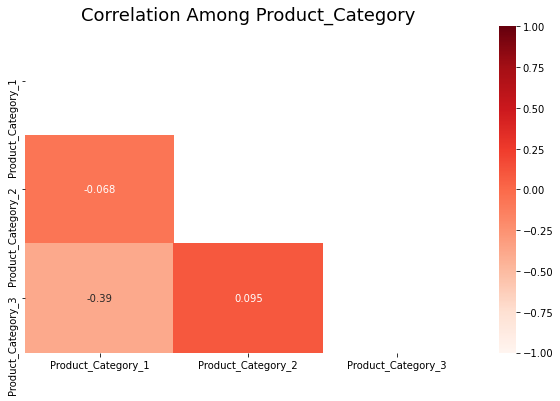

In [171]:
#The similarity between different product_category
df_sample = df_filled.select(['Product_Category_1','Product_Category_2','Product_Category_3']).toPandas()   
corr_matrix = df_sample.corr()  
mask = np.triu(np.ones_like(corr_matrix))  
  
fig, ax = plt.subplots(figsize=(10, 6))  
sns.heatmap(corr_matrix, annot=True, cmap="Reds", vmin=-1, vmax=1, mask=mask)  
plt.title('Correlation Among Product_Category', color='black', fontsize=18)  
plt.show()

#### Regression algorithm prediction of purchases

In [53]:
# Regression
#occu_indexer = StringIndexer(inputCol="Occupation", outputCol="occu")
gender_indexer = StringIndexer(inputCol="Gender", outputCol="Gender_n")  
city_category_indexer = StringIndexer(inputCol="City_Category", outputCol="City_Category_n")  
stay_years_indexer = StringIndexer(inputCol="Stay_In_Current_City_Years", outputCol="Stay_In_Current_City_Years_n") 
 
purchase_category_indexer = StringIndexer(inputCol="Purchase_Category", outputCol="Cat")
    
pipeline = Pipeline(stages=[gender_indexer, city_category_indexer, stay_years_indexer,purchase_category_indexer])  
   
df_tr = pipeline.fit(selected_df).transform(selected_df)    
df_tr.show(10)

+------+----------+-------------+--------------------------+--------------+-----+------------------+----+--------+---------------+----------------------------+---+
|Gender|Occupation|City_Category|Stay_In_Current_City_Years|Marital_Status|  Age| Purchase_Category|occu|Gender_n|City_Category_n|Stay_In_Current_City_Years_n|Cat|
+------+----------+-------------+--------------------------+--------------+-----+------------------+----+--------+---------------+----------------------------+---+
|     F|        10|            A|                         2|             0| 0-17|   Less Than 10000|12.0|     1.0|            2.0|                         1.0|0.0|
|     F|        10|            A|                         2|             0| 0-17|Greater Than 15000|12.0|     1.0|            2.0|                         1.0|1.0|
|     F|        10|            A|                         2|             0| 0-17|    Less Than 5000|12.0|     1.0|            2.0|                         1.0|2.0|
|     F|        

In [56]:
assembler = VectorAssembler(inputCols=['Occupation','Marital_Status','Gender_n','City_Category_n','Stay_In_Current_City_Years_n'], outputCol="features")  
output = assembler.transform(df_tr).select(['features','Cat']) 
output.show(5)

+--------------------+---+
|            features|Cat|
+--------------------+---+
|[10.0,0.0,1.0,2.0...|0.0|
|[10.0,0.0,1.0,2.0...|1.0|
|[10.0,0.0,1.0,2.0...|2.0|
|[10.0,0.0,1.0,2.0...|2.0|
|[16.0,0.0,0.0,1.0...|0.0|
+--------------------+---+
only showing top 5 rows



In [89]:
#Normalize
normaliser = StandardScaler(inputCol="features", outputCol="normFeatures")
normModel = normaliser.fit(output)
norm = normModel.transform(output)
features_norm = station_norm.select(["normFeatures", "Cat"])
features_norm.show(5)

+--------------------+---+
|        normFeatures|Cat|
+--------------------+---+
|[1.53311674268597...|0.0|
|[1.53311674268597...|1.0|
|[1.53311674268597...|2.0|
|[1.53311674268597...|2.0|
|[2.45298678829755...|0.0|
+--------------------+---+
only showing top 5 rows



In [138]:
#Separate the dateset into training set and testset
training_data, test_data = features_norm.randomSplit([0.7, 0.3],seed=15) 

In [87]:
# a. Linear Regressor  
lr = LinearRegression(featuresCol="normFeatures", labelCol="Cat")  
lr_model = lr.fit(training_data)  
  
# b. Decision Tree Regressor  
dt = DecisionTreeRegressor(featuresCol="normFeatures", labelCol="Cat")  
dt_model = dt.fit(training_data)  
  
# c. Random Forest Regressor  
rf = RandomForestRegressor(featuresCol="normFeatures", labelCol="Cat")  
rf_model = rf.fit(training_data)  

In [92]:
# Prediction 
lr_predictions = lr_model.transform(test_data)  
dt_predictions = dt_model.transform(test_data)  
rf_predictions = rf_model.transform(test_data) 

In [93]:
# Evaluate 
evaluator = RegressionEvaluator(  
    labelCol="Cat",   
    predictionCol="prediction",   
    metricName="rmse"    
)  
  
# Evaluate for LinearRegression 
lr_rmse = evaluator.evaluate(lr_predictions)  
print(f"Linear Regression RMSE: {lr_rmse}")  
  
# Evaluate for DecisionTreeRegression 
dt_rmse = evaluator.evaluate(dt_predictions)  
print(f"Decision Tree Regression RMSE: {dt_rmse}")  
  
# Evaluate RandomTreeRegression 
rf_rmse = evaluator.evaluate(rf_predictions)  
print(f"Random Forest Regression RMSE: {rf_rmse}")  

Linear Regression RMSE: 1.1811895413500302
Decision Tree Regression RMSE: 1.1805117689097198
Random Forest Regression RMSE: 1.1805408212279798


The Root Mean Squared Error (RMSE) is a measure of the standard deviation of prediction errors. It provides an indication of how spread out the residuals are from the mean prediction error. A lower RMSE value indicates better predictive performance, as it means the predictions are closer to the actual observed values.

The RMSE values suggest that the performance of all three models is quite similar. The Decision Tree and Random Forest Regression models have slightly lower RMSE values than Linear Regression, but the differences are minimal and may not translate into significant practical differences.

In [182]:
spark.stop()